# 제조 공정 예측 유지 보수하기

## 01. 데이터 소개 및 분석 프로세스 수립

### 데이터 수집  
데이터 소스: https://www.kaggle.com/datasets/yuansaijie0604/xinjiang-pm?resource=download  

사용되는 데이터 파일 목록
- PdM error
- PdM failure
- PdM machines
- PdM components
- PdM telemetry.

### 데이터 전처리  
각 데이터별 전처리 진행  

Feature 종류
- 일정 시간 통계량 Feature
- 범주형 Feature
- Target Feature

### 모델 생성  
- XGBoost Model 생성
- 모델 평가

### 모델 평가 및 의사결정
- Feature Importance

matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [2]:
! pip install scikit-learn
! pip install scikit-plot

In [3]:
# 필요한 파이썬 라이브러리 불러오기

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

import scikitplot as skplt

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as XGBRFRegressor

import warnings
warnings.filterwarnings("ignore")

In [5]:
telemetry = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_telemetry.csv", error_bad_lines=False)
errors = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_errors.csv", error_bad_lines=False)
maint = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_maint.csv", error_bad_lines=False)
failures = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_failures.csv", error_bad_lines=False)
machines = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_machines.csv", error_bad_lines=False)

Skipping line 92490: expected 6 fields, saw 9



In [6]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


### 1. 각 데이터별 전처리

#### telemetry

In [7]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [8]:
telemetry["machineID"].nunique()

100

> 데이터 타입

In [9]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968588 entries, 0 to 968587
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   968588 non-null  object 
 1   machineID  968588 non-null  int64  
 2   volt       968588 non-null  float64
 3   rotate     968588 non-null  float64
 4   pressure   968588 non-null  float64
 5   vibration  968588 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.3+ MB


In [10]:
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

> 변수별 분포

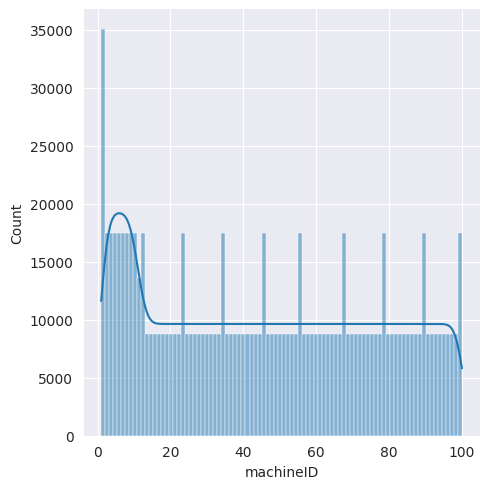

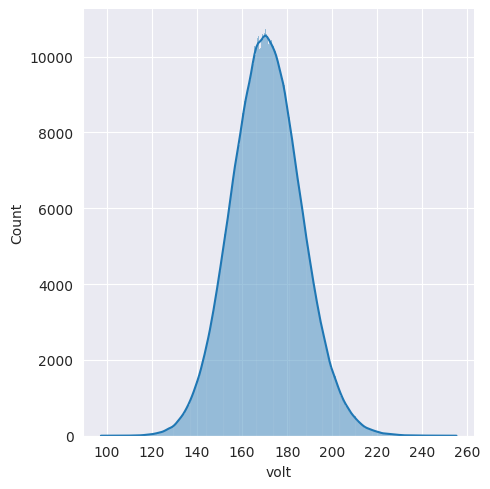

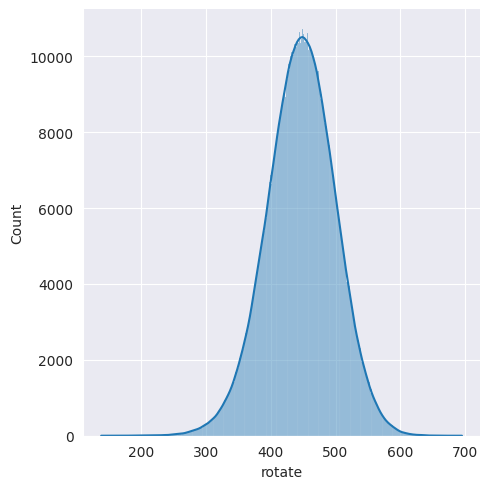

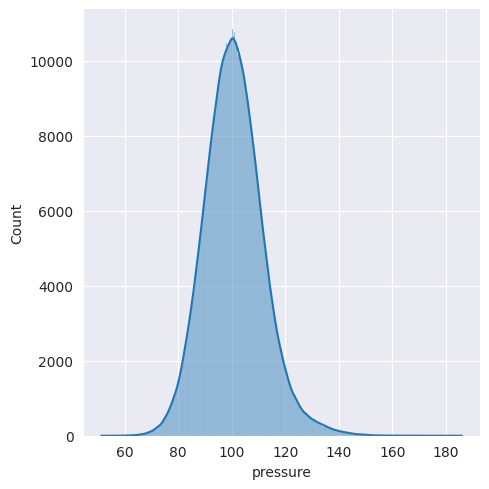

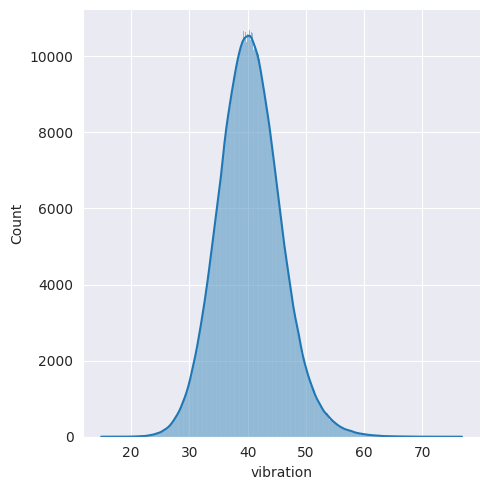

In [12]:
# 데이터 컬럼 타입이 np.number인 것만 가져오기
numeric_data = telemetry.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 np.number인 컬럼 이름들 가져오기
l = numeric_data.columns.values
number_of_columns = 4
number_of_rows = len(l) - 1 / number_of_columns

# 컬럼별 히스토그램 그리기
for i in range(0, len(l)):
  target_data = numeric_data[l[i]]

  target_data_wo_zero = target_data[target_data>0]
  sns.displot(target_data_wo_zero, kde=True)

> 시계열 그래프 그려보기

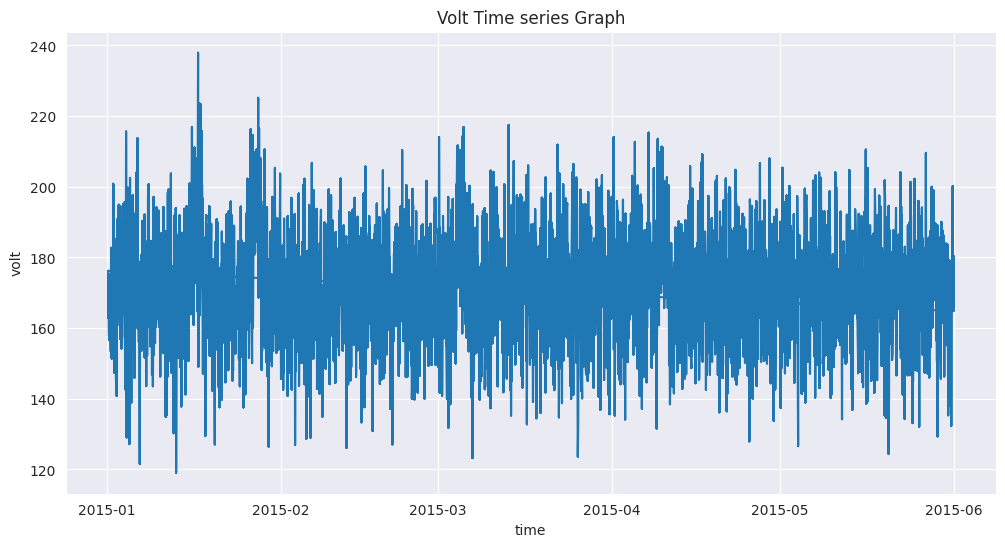

In [13]:
plot_df = telemetry.loc[
    (telemetry["machineID"] == 1)
    & (telemetry["datetime"] > pd.to_datetime("2015-01-01"))
    & (telemetry["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "volt"]
]

plt.figure(figsize=(12, 6))
plt.plot(plot_df["datetime"], plot_df["volt"])
plt.title("Volt Time series Graph")
plt.ylabel("volt")

adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m=%d"
plt.xlabel("time")
plt.show()

#### errors

In [14]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [15]:
errors.tail()

,datetime,machineID,errorID
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [16]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


> 데이터 타입

In [17]:
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")
errors["errorID"] = errors["errorID"].astype("category")
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


> 컬럼별 개수

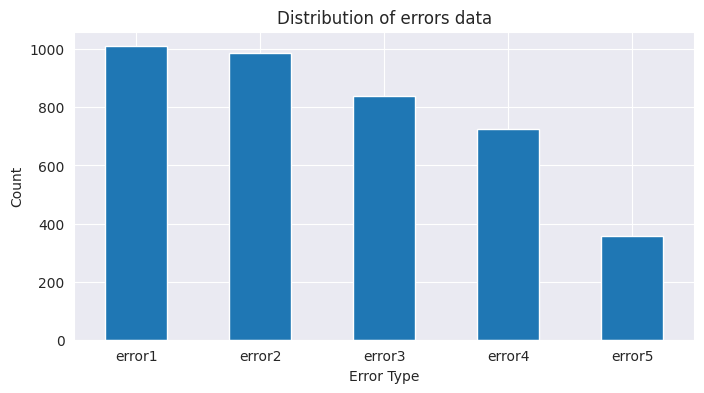

In [18]:
plt.figure(figsize=(8, 4))
errors["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of errors data")
plt.ylabel("Count")
plt.xlabel("Error Type")
plt.show()

#### maint

In [19]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [20]:
maint.tail()

,datetime,machineID,comp
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


In [21]:
maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


> 데이터 타입

In [22]:
maint["datetime"] = pd.to_datetime(maint["datetime"], format="%Y-%m-%d %H:%M:%S")
maint["comp"] = maint["comp"].astype("category")
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

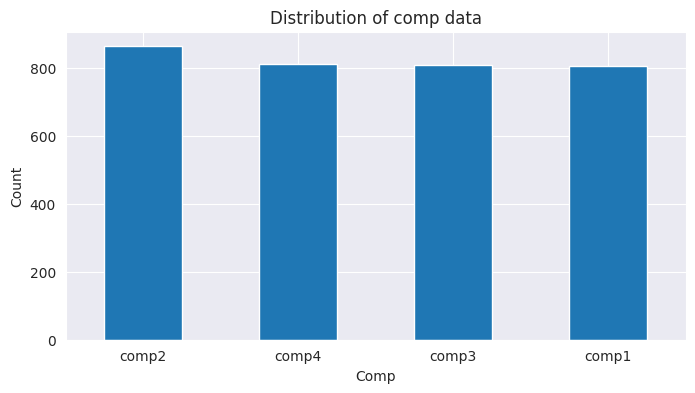

In [23]:
plt.figure(figsize=(8, 4))
maint["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of comp data")
plt.ylabel("Count")
plt.xlabel("Comp")
plt.show()

#### machines

In [24]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [25]:
machines.tail()

,machineID,model,age
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14
99,100,model4,5


In [26]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


> 데이터 타입

In [27]:
machines['model'] = machines["model"].astype("category")
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

> 모델 번호별 age 분포

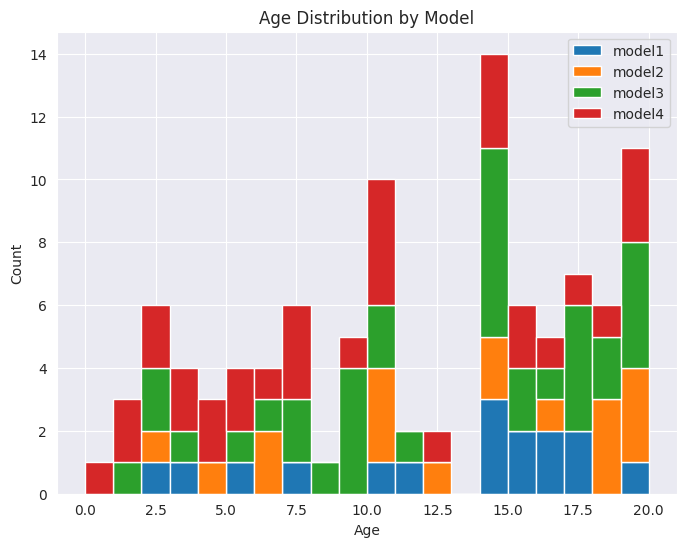

In [28]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    machines.loc[machines["model"] == "model1", "age"],
    machines.loc[machines["model"] == "model2", "age"],
    machines.loc[machines["model"] == "model3", "age"],
    machines.loc[machines["model"] == "model4", "age"]],
                      20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Age Distribution by Model")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

#### failures

In [29]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [30]:
failures.tail()

,datetime,machineID,failure
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


In [33]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


> 데이터 타입

In [34]:
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
failures["failure"] = failures["failure"].astype("category")
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
dtype: object

In [35]:
failures.describe(include="all")

,datetime,machineID,failure
count,761,761.000000,761
unique,302,NaN,4
top,2015-01-02 03:00:00,NaN,comp2
freq,18,NaN,259
first,2015-01-02 03:00:00,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN
mean,NaN,51.911958,NaN
std,NaN,29.515542,NaN
min,NaN,1.000000,NaN
25%,NaN,24.000000,NaN


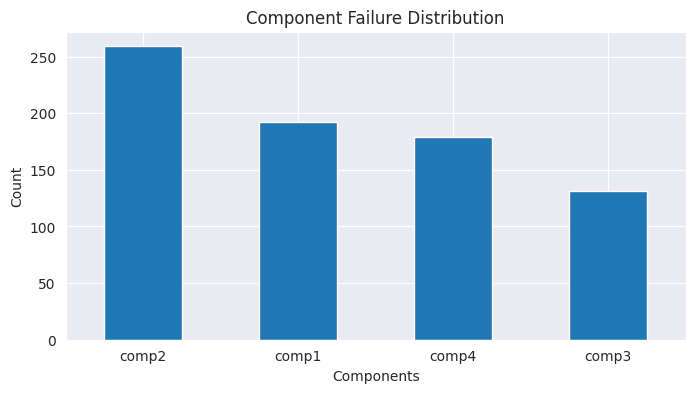

In [36]:
plt.figure(figsize=(8, 4))
failures["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Component Failure Distribution")
plt.ylabel("Count")
plt.xlabel("Components")
plt.show()